In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fdm.src.fdm3t import fdm3t
from fdm.src.mfgrid import Grid
import etc

Wh(0.001, 0.3)  = (2.7449201210813685, 4.580772753804319e-09)
Wh(0.01, 0.3)   = (2.7104287908047175, 1.8261895390546826e-09)
Wh(0.1, 0.3)    = (1.6703650224009043, 5.50906758939597e-09)


In [2]:
dtypeQ   = np.dtype([('I', np.int32), ('q', float)])
dtypeH   = np.dtype([('I', np.int32), ('h', float)])
dtypeGHB = np.dtype([('I', np.int32), ('h', float), ('C', float)])

In [3]:
def kraaij(t=None, x=None, D=None, kx=None, kz=None, ss=None, dh=None, epsilon=1.0, **kw):
    """Return Kraaijenhoff vd Leur output in a one-layer model.

    If np.all(ss == 0.), steady state should be returned. For this, at least
    one cell must be fixed head (as specified by fh).
    """

    def kraaijenhoff(kD=None, S=None, t=None, x=None, dh=None):
        """Return Kraaijenhoff vd Leur solution."""
        if np.isscalar(t):
            t = np.array(t) .reshape(1, 1)

        b = x[-1]
        t = t[:, np.newaxis]
        xm = 0.5 * (x[:-1] + x[1:])
        xm = xm[np.newaxis, :]

        s = np.zeros((t.shape[0], xm.shape[-1]))
        for j in range(1, 20):
            _2jm1 = 2 * j - 1
            T = b ** 2 * S / kD
            s +=  (-1) ** (j - 1) / _2jm1 * np.cos(_2jm1 * np.pi / 2 * xm / b) * np.exp(-(_2jm1 * np.pi / 2) ** 2 * t /T)
        return dh * 4  / np.pi * s

    x = np.hstack((0., x[x > 0]))
    kD = (kx * D).sum()
    S  = (ss * D).sum()

    T = x[-1] ** 2 * S / kD * (2 / np.pi) ** 2
    tkrvdl = np.arange(1, 11) * T
    t = np.unique(np.hstack((t, tkrvdl)))

    z = -np.cumsum(np.hstack((0, D)))
    gr = Grid(x, [-0.5, 0.5], z, axial=False)

    krvdl = kraaijenhoff(kD=kD, S=S, t=tkrvdl, x=x, dh=dh)

    idomain = gr.const(1, dtype=int)
    hi = gr.const(dh)

    fh = np.zeros(gr.nz * gr.ny, dtype=dtypeH)
    fh['I'], fh['h'] = gr.NOD[:, :, -1].ravel(), 0.
    fh = {0: fh}

    out = fdm3t(gr=gr, t=t, k=(kx, kx, kz), ss=ss, fh=fh, fq=None, hi=hi, idomain=idomain, epsilon=epsilon)

    ax = etc.newfig(kw['title'],
        'x [m]',
        'h - h0 [m]')

    cc = etc.color_cycler()
    for it, t_ in enumerate(t):
        if t_ not in tkrvdl:
            continue
        color = next(cc)
        ax.plot(gr.xm, out['Phi'][it, -1, 0, :], '-', color=color, label=f't={t_:.4g} d')
    cc = etc.color_cycler()
    for it, t_ in enumerate(tkrvdl):
        color = next(cc)
        ax.plot(gr.xm, krvdl[it, :], '.', color=color, label=f'krvl, t={t_:.4g} d')
    ax.legend()
    return ax

In [4]:
kraaij_kwargs = {
        'title': r"""Kraaijenhoff vd Leur, 1D head development after sudden change of head at x +/- b.
         """,
         'comment': """Kraaij.
         Computes the head change in a cross section after chaning the head at +/-b suddenly at t=0
         """,
        't': np.logspace(-3, 3, 61),
        'x': np.linspace(0, 1000.0, 2 * 100),
        'D': np.array([50.]),
        'kx': np.array([10.]),
        'kz': np.array([1e6]),
        'ss': np.array([1e-3]),
        'dh': 1.0,
        'epsilon': 0.5
        }

<Axes: title={'center': 'Kraaijenhoff vd Leur, 1D head development after sudden change of head at x +/- b.\n         '}, xlabel='x [m]', ylabel='h - h0 [m]'>

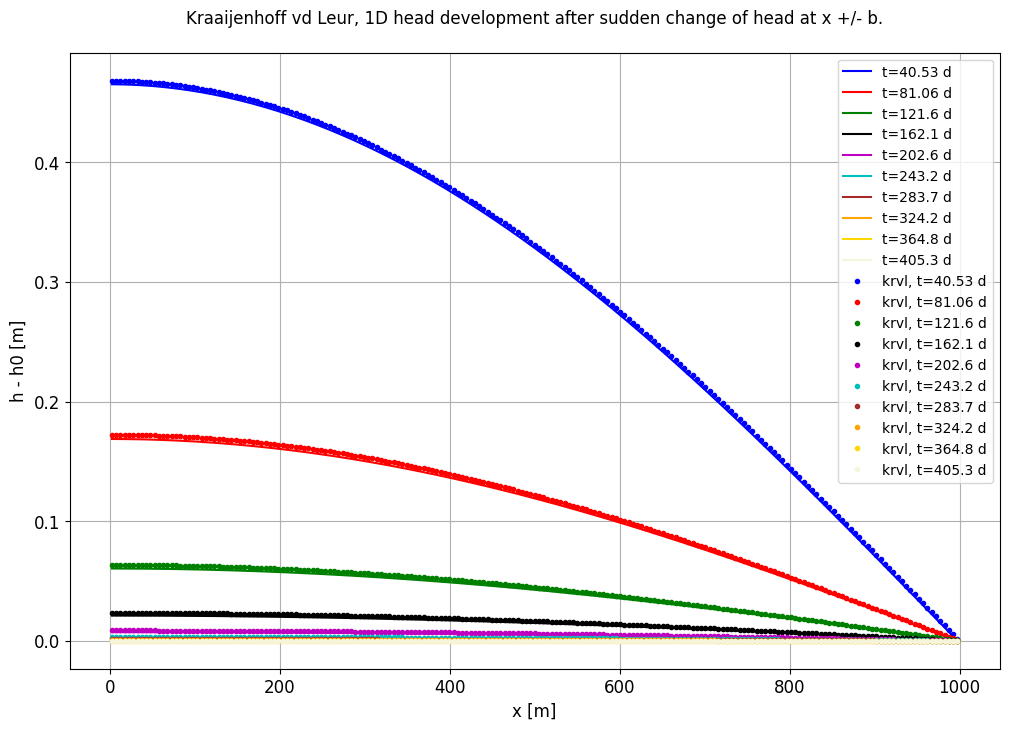

In [5]:
kraaij(**kraaij_kwargs)